# Запуск Экспериментов в Azure ML

## 1. Соединение со своим Workspace

Импорт модулей:

In [1]:
import os

import azureml.core
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.datastore import Datastore

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import json


# Check core SDK version number
print(f'SDK version: {azureml.core.VERSION}')

SDK version: 1.12.0


Создаем соединение со своим Workspace:

In [2]:
ws = Workspace.from_config()
print('Connected Workspace:', ws.name, ws.resource_group, ws.location, sep = '\n')

Connected Workspace:
ai-in-cloud-workspace
ai-in-cloud-workshop-rg
westeurope


## 2. Загрузка данных для Эксперимента

Воспользуемся данными загружеными на [прошлом лабораторном занятии](../module-3/azure-datastore.ipynb):

In [3]:
# Get uploaded data 
ds = ws.get_default_datastore()
diabetes_ds = Dataset.Tabular.from_delimited_files(path=(ds, 'diabetes-data/*.csv'))

data = diabetes_ds.to_pandas_dataframe()
data[1:10]

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
1,1823377,0,116,92,16,184,18.603630,0.131156,22,0
2,1916381,8,171,42,29,160,35.482247,0.082671,22,1
3,1247480,3,108,63,45,297,49.375169,0.100979,46,1
4,1516947,8,153,99,15,41,35.062139,0.116191,22,1
5,1703500,0,81,90,17,38,41.658026,0.478649,21,0
6,1040668,0,82,52,45,42,40.757542,0.082352,26,0
7,1358192,4,96,83,26,34,52.945331,0.160199,53,1
8,1023245,3,103,54,47,94,55.149428,0.316475,21,1
9,1363912,11,99,60,12,737,32.898198,0.108512,46,1


## 3. Запуск Эксперимента

Создадим Эксперимент и залоггируем основыне данные об эксперименте и данных используемых в нем:

In [19]:
# Create an Azure ML experiment
experiment = Experiment(workspace=ws, name='diabetes-experiment')

# Create an interactive run
run = experiment.start_logging()
run.tag('diabetes')
run.tag('azure-ml-course')

run.log('Dataset dimension', f'{data.shape[0]}x{data.shape[1]}')
run.log('Yet another important fact', 'Think about it')

print(f'Starting experiment {experiment.name}...')

Starting experiment diabetes-experiment...


Проанализируем количество пациентов с диабетом и без и залогируем результаты:

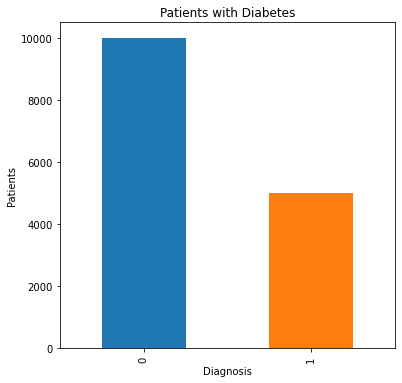

In [5]:
# Plot and log the count of diabetic vs non-diabetic patients
diabetic_counts = data['Diabetic'].value_counts()

fig = plt.figure(figsize=(6,6))
ax = fig.gca()    

diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name = 'label distribution', plot = fig)

# log distinct pregnancy counts
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

Посчитаем описательные статистики датасета и залогируем результаты:

In [7]:
# Log summary statistics for numeric columns
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])

Сохраним 100 случайных строк из дасета в выходные данные Эксперимента:

In [8]:
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream = './sample.csv')

Завершим эксперимент:

In [20]:
# Complete the run
run.complete()

## 4. Просмотр результатов Эксперимента

Детали эксперимента:

In [10]:
details = run.get_details()
print(details)

{'runId': '835d1644-1f91-4218-9e9c-0d8aaaeba26c', 'target': 'local', 'status': 'Completed', 'startTimeUtc': '2020-09-06T11:09:53.173706Z', 'endTimeUtc': '2020-09-06T11:10:53.781656Z', 'properties': {'azureml.git.repository_uri': 'https://github.com/codez0mb1e/AI-in-cloud-workshop.git', 'mlflow.source.git.repoURL': 'https://github.com/codez0mb1e/AI-in-cloud-workshop.git', 'azureml.git.branch': 'azure-ml-ru', 'mlflow.source.git.branch': 'azure-ml-ru', 'azureml.git.commit': '0108d6f69aa4328644daeab984b3f16452d793ca', 'mlflow.source.git.commit': '0108d6f69aa4328644daeab984b3f16452d793ca', 'azureml.git.dirty': 'True', 'ContentSnapshotId': 'caf9fe08-a9fa-4a06-89c8-10b0f5fbb0fb'}, 'inputDatasets': [], 'outputDatasets': [], 'logFiles': {}}


Метрики эксперимента:

In [11]:
metrics = run.get_metrics()
print(json.dumps(metrics, indent=2))

{
  "Name": "diabetes-experiment",
  "Tags": "diabetes",
  "Dataset dimension": [
    15000,
    10
  ],
  "Time": "datetime.datetime(2020, 9, 6, 11, 9, 54, 963655)",
  "label distribution": "aml://artifactId/ExperimentRun/dcid.835d1644-1f91-4218-9e9c-0d8aaaeba26c/label distribution_1599390595.png",
  "pregnancy categories": [
    1,
    0,
    8,
    3,
    4,
    11,
    2,
    6,
    7,
    9,
    10,
    13,
    5,
    12,
    14
  ],
  "PlasmaGlucose": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      15000.0,
      107.85686666666666,
      31.98197465181073,
      44.0,
      84.0,
      104.0,
      129.0,
      192.0
    ]
  },
  "DiastolicBloodPressure": {
    "stat": [
      "count",
      "mean",
      "std",
      "min",
      "25%",
      "50%",
      "75%",
      "max"
    ],
    "value": [
      15000.0,
      71.22066666666667,
      16.75871603653161,
      24.0,
      

Выходные данные:

In [12]:
files = run.get_file_names()
print(json.dumps(files, indent=2))

[
  "label distribution_1599390595.png",
  "outputs/sample.csv"
]


Визуализируем данные с помощью виджета:

In [13]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Перейдите по сссылке, которая появилась в виджете, чтобы просмотеть результаты Эксперимента на протале Azure ML.